In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency, mannwhitneyu, shapiro
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import missingno as msn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')

In [4]:
test=pd.read_csv('/kaggle/input/titanic/test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data Union

In [8]:
dataset=pd.concat([train, test], ignore_index=True)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [10]:
dataset.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [11]:
dataset.Sex.value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [12]:
dataset.SibSp.value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [13]:
dataset.Parch.value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [14]:
dataset.Ticket.value_counts()

CA. 2343    11
1601         8
CA 2144      8
347082       7
347077       7
            ..
347078       1
239059       1
363272       1
PC 17531     1
384461       1
Name: Ticket, Length: 929, dtype: int64

In [15]:
dataset.Cabin.value_counts()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
D                  4
F4                 4
                  ..
B61                1
B102               1
A21                1
D40                1
B101               1
Name: Cabin, Length: 186, dtype: int64

In [16]:
dataset.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

# Train - Test Data missing value

# Train Data

In [17]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

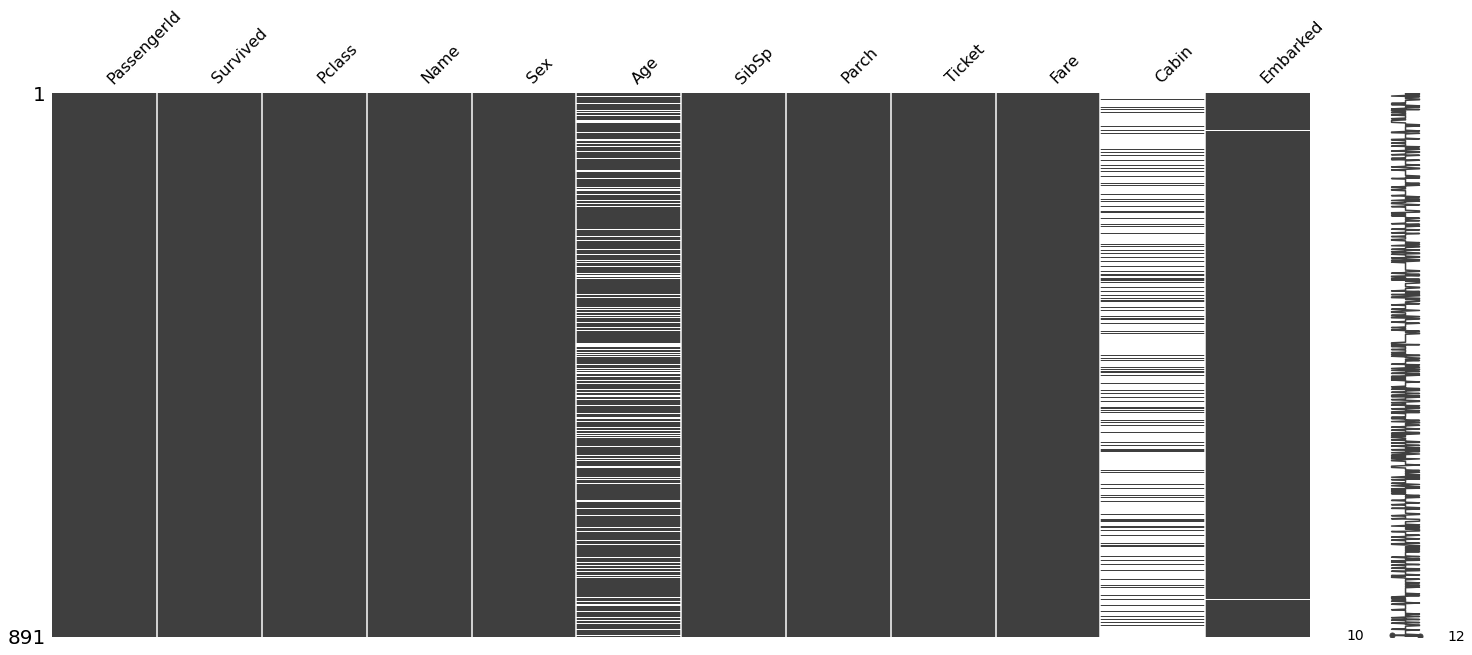

In [18]:
msn.matrix(train);

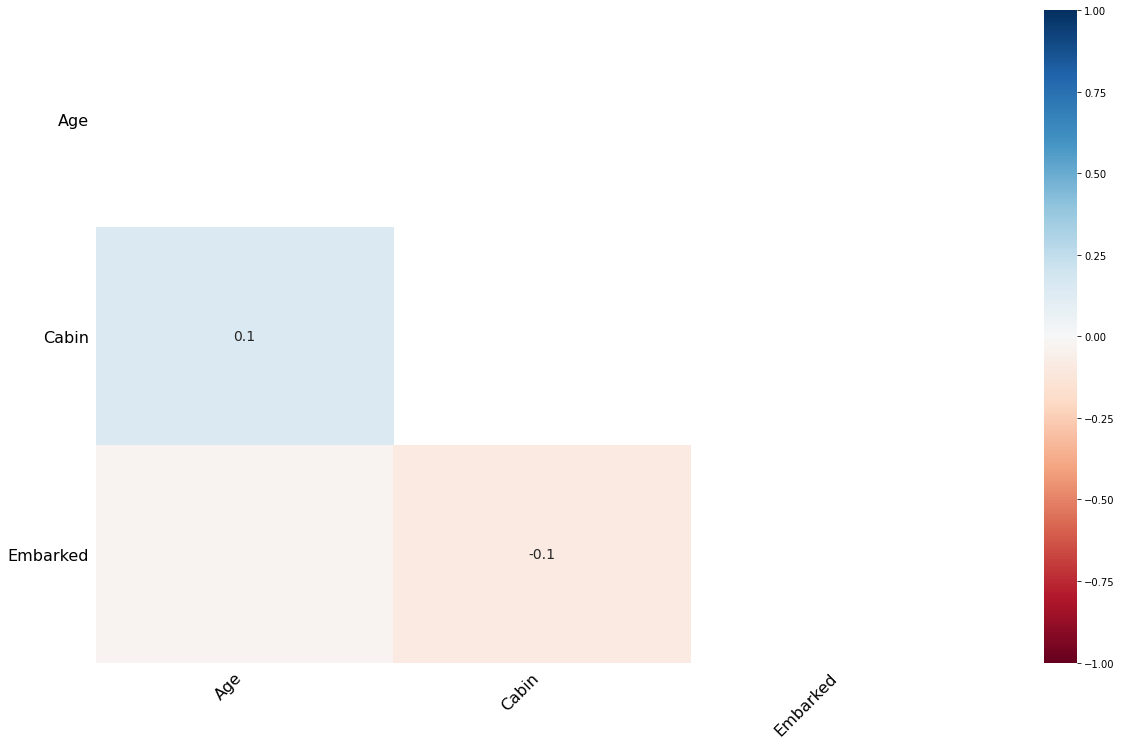

In [19]:
msn.heatmap(train);

In [20]:
train.Age.isnull().sum()

177

In [21]:
print(train.Age.skew())
print(train.Age.kurtosis())

0.38910778230082704
0.17827415364210353


In [22]:
train.Age.fillna(train.Age.median(), inplace=True)

In [23]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [24]:
train.Embarked.isnull().sum()

2

In [25]:
train.Embarked.fillna("S", inplace=True)

In [26]:
train.Cabin.isnull().sum()

687

In [27]:
train.Cabin.value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
D              3
F2             3
              ..
E36            1
D45            1
E31            1
C90            1
B101           1
Name: Cabin, Length: 147, dtype: int64

In [28]:
train.Cabin=np.where(train.Cabin.isnull(), "unknown", train.Cabin)

In [29]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [30]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknown,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknown,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknown,S


# Test verisi

In [31]:
test.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

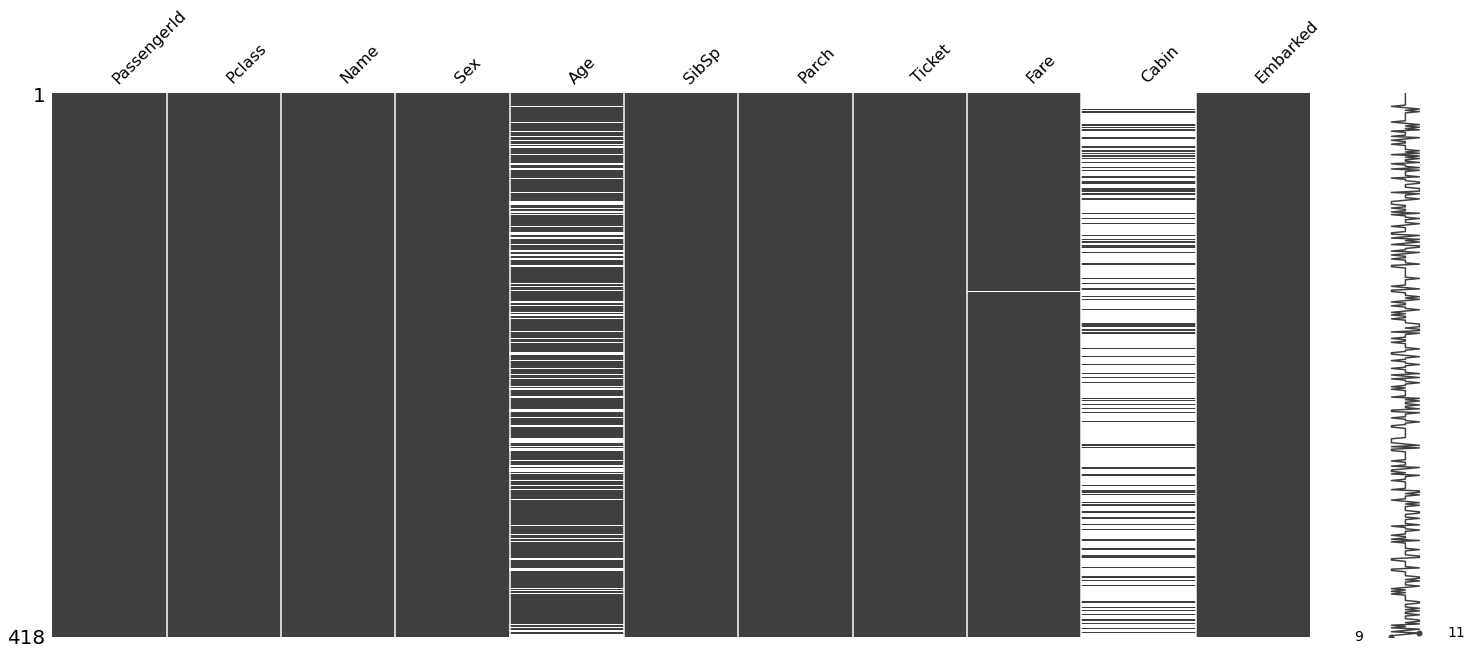

In [32]:
msn.matrix(test);

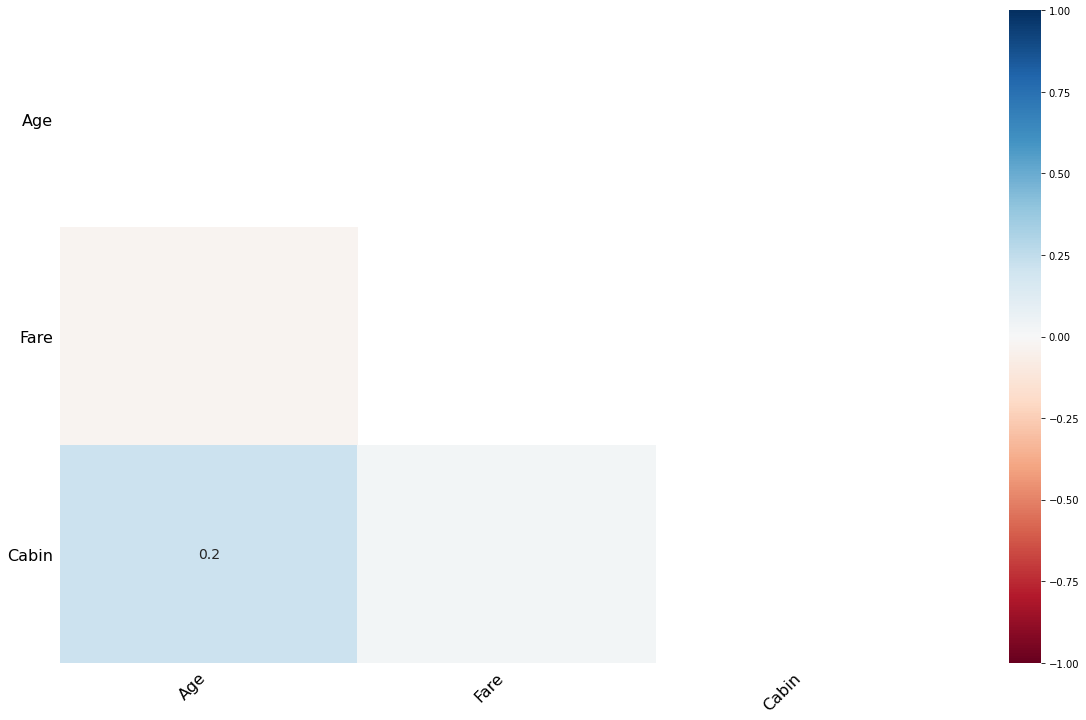

In [33]:
msn.heatmap(test);

In [34]:
test.select_dtypes(exclude="object").describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


In [35]:
test.Age.isnull().sum()

86

In [36]:
print(test.Age.skew())
print(test.Age.kurtosis())

0.4573612871503845
0.08378335153796135


In [37]:
test.Age.fillna(test.Age.median(), inplace=True)

In [38]:
test.Fare.isnull().sum()

1

In [39]:
test.Fare.fillna(test.Fare.median(), inplace=True)

In [40]:
test.Cabin.isnull().sum()

327

In [41]:
test.Cabin=np.where(test.Cabin.isnull(), "unknown", test.Cabin)

In [42]:
test.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [43]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,unknown,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,unknown,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,unknown,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,unknown,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,unknown,S


# Train Data Exploratory data analysis

In [44]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknown,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknown,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknown,S


In [45]:
train.select_dtypes(exclude="object").describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


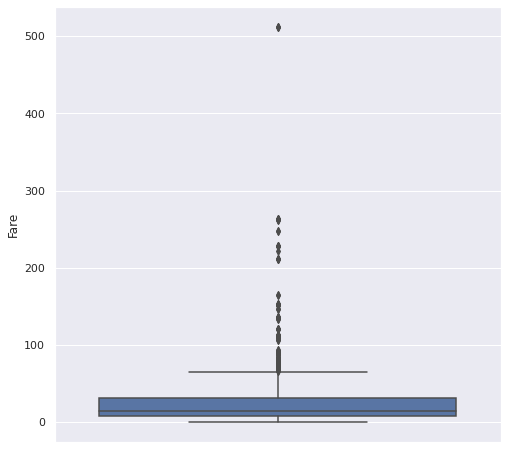

In [46]:
sns.set(rc={'figure.figsize': (8, 8)})
sns.boxplot(x=train.Fare,orient="v");

# Outlier Detection for Variable "Fare"

In [47]:
Q1=train.Fare.quantile(0.25)
Q3=train.Fare.quantile(0.75)
IQR=Q3-Q1

lower_limit=Q1-1.5*IQR
upper_limit=Q3+1.5*IQR
IQR,lower_limit,upper_limit

(23.0896, -26.724, 65.6344)

In [48]:
freq_outliers = ((train.Fare < lower_limit) | (train.Fare > upper_limit)).value_counts()
freq_outliers

False    775
True     116
Name: Fare, dtype: int64

In [49]:
outliers_bool = ((train.Fare < lower_limit) | (train.Fare > upper_limit))
outliers_bool.head()

0    False
1     True
2    False
3    False
4    False
Name: Fare, dtype: bool

In [50]:
outliers=train.Fare[outliers_bool]

In [51]:
outliers.head()

1      71.2833
27    263.0000
31    146.5208
34     82.1708
52     76.7292
Name: Fare, dtype: float64

# Imputation of Fare with median

In [52]:
train.Fare[outliers_bool]=train.Fare.median()
train.Fare[outliers_bool]

1      14.4542
27     14.4542
31     14.4542
34     14.4542
52     14.4542
        ...   
846    14.4542
849    14.4542
856    14.4542
863    14.4542
879    14.4542
Name: Fare, Length: 116, dtype: float64

In [53]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.50,891.0
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.00,1.0
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.00,3.0
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.00,80.0
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.00,8.0
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.00,6.0
Fare,891.0,17.383622,12.713016,0.00,7.9104,14.4542,24.15,65.0


# Questioning of multicollinearity

In [54]:
train[["Age", "SibSp", "Parch", "Fare"]].corr(method="spearman")

,Age,SibSp,Parch,Fare
Age,1.000000,-0.145316,-0.217488,0.083702
SibSp,-0.145316,1.000000,0.450014,0.449552
Parch,-0.217488,0.450014,1.000000,0.415328
Fare,0.083702,0.449552,0.415328,1.000000


In [55]:
spearmanr(train.SibSp, train.Fare)

SpearmanrResult(correlation=0.4495523861186016, pvalue=1.5467407769252874e-45)

In [56]:
spearmanr(train.Fare, train.Parch)

SpearmanrResult(correlation=0.41532774326569516, pvalue=1.7997576904221345e-38)

In [57]:
spearmanr(train.SibSp, train.Parch)

SpearmanrResult(correlation=0.4500139710086164, pvalue=1.226001634071391e-45)

# Calculation of VIF

In [58]:
X=train.copy()

In [59]:
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=0)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]

X = X[["Age", "SibSp", "Parch", "Fare"]] # Selecting your data

X2 = calculate_vif_(X,5) # Actually running the function

4
Remaining variables:
[['Age', 'SibSp', 'Parch', 'Fare']]


# Distribution of dependent variables in variable "Survived" 

# Pclass

In [60]:
pd.crosstab(train.Survived, train.Pclass, margins=True, margins_name="Total")

Pclass,1,2,3,Total
Survived,,,,
0,80,97,372,549
1,136,87,119,342
Total,216,184,491,891


In [61]:
obs=np.matrix(pd.crosstab(train.Survived, train.Pclass))

In [62]:
chi2_contingency(obs)

(102.88898875696056,
 4.549251711298793e-23,
 2,
 array([[133.09090909, 113.37373737, 302.53535354],
        [ 82.90909091,  70.62626263, 188.46464646]]))

# Sex

In [63]:
pd.crosstab(train.Survived, train.Sex, margins=True, margins_name="Total")

Sex,female,male,Total
Survived,,,
0,81,468,549
1,233,109,342
Total,314,577,891


In [64]:
obs=np.matrix(pd.crosstab(train.Survived, train.Sex))

In [65]:
chi2_contingency(obs)

(260.71702016732104,
 1.1973570627755645e-58,
 1,
 array([[193.47474747, 355.52525253],
        [120.52525253, 221.47474747]]))

# SibSp

In [66]:
pd.crosstab(train.Survived, train.SibSp, margins=True, margins_name="Total")

SibSp,0,1,2,3,4,5,8,Total
Survived,,,,,,,,
0,398,97,15,12,15,5,7,549
1,210,112,13,4,3,0,0,342
Total,608,209,28,16,18,5,7,891


In [67]:
obs=np.matrix(pd.crosstab(train.Survived, train.SibSp))

In [68]:
chi2_contingency(obs)

(37.27179291520431,
 1.5585810465902116e-06,
 6,
 array([[374.62626263, 128.77777778,  17.25252525,   9.85858586,
          11.09090909,   3.08080808,   4.31313131],
        [233.37373737,  80.22222222,  10.74747475,   6.14141414,
           6.90909091,   1.91919192,   2.68686869]]))

# Parch

In [69]:
pd.crosstab(train.Survived, train.Parch, margins=True, margins_name="Total")

Parch,0,1,2,3,4,5,6,Total
Survived,,,,,,,,
0,445,53,40,2,4,4,1,549
1,233,65,40,3,0,1,0,342
Total,678,118,80,5,4,5,1,891


In [70]:
obs=np.matrix(pd.crosstab(train.Survived, train.Parch))

In [71]:
chi2_contingency(obs)

(27.925784060236168,
 9.703526421039997e-05,
 6,
 array([[4.17757576e+02, 7.27070707e+01, 4.92929293e+01, 3.08080808e+00,
         2.46464646e+00, 3.08080808e+00, 6.16161616e-01],
        [2.60242424e+02, 4.52929293e+01, 3.07070707e+01, 1.91919192e+00,
         1.53535354e+00, 1.91919192e+00, 3.83838384e-01]]))

# Cabin

In [72]:
train["Cabin"]=train["Cabin"].map(lambda x: str(x)[:1])

In [73]:
pd.crosstab(train.Survived, train.Cabin, margins=True, margins_name="Total")

Cabin,A,B,C,D,E,F,G,T,u,Total
Survived,,,,,,,,,,
0,8,12,24,8,8,5,2,1,481,549
1,7,35,35,25,24,8,2,0,206,342
Total,15,47,59,33,32,13,4,1,687,891


In [74]:
obs=np.matrix(pd.crosstab(train.Survived, train.Cabin))

In [75]:
chi2_contingency(obs)

(99.16416061888009,
 6.326020042314704e-18,
 8,
 array([[9.24242424e+00, 2.89595960e+01, 3.63535354e+01, 2.03333333e+01,
         1.97171717e+01, 8.01010101e+00, 2.46464646e+00, 6.16161616e-01,
         4.23303030e+02],
        [5.75757576e+00, 1.80404040e+01, 2.26464646e+01, 1.26666667e+01,
         1.22828283e+01, 4.98989899e+00, 1.53535354e+00, 3.83838384e-01,
         2.63696970e+02]]))

# Cabin/unknown is higher within deads so Pclass 3rd maybe related with this?

In [76]:
pd.crosstab(train.Survived, [train.Pclass, train.Cabin], margins=True, margins_name="Total")

Pclass     1                         2             3            Total
Cabin      A   B   C   D   E  T   u  D  E  F    u  E  F  G    u      
Survived                                                             
0          8  12  24   7   7  1  21  1  1  1   94  0  4  2  366   549
1          7  35  35  22  18  0  19  3  3  7   74  3  1  2  113   342
Total     15  47  59  29  25  1  40  4  4  8  168  3  5  4  479   891

# Embarked

In [77]:
pd.crosstab(train.Survived, train.Embarked, margins=True, margins_name="Total")

Embarked,C,Q,S,Total
Survived,,,,
0,75,47,427,549
1,93,30,219,342
Total,168,77,646,891


In [78]:
obs=np.matrix(pd.crosstab(train.Survived, train.Embarked))

In [79]:
chi2_contingency(obs)

(25.964452881874784,
 2.3008626481449577e-06,
 2,
 array([[103.51515152,  47.44444444, 398.04040404],
        [ 64.48484848,  29.55555556, 247.95959596]]))

# Age

In [80]:
train.groupby("Survived")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,30.028233,12.499986,1.00,23.0,28.0,35.0,74.0
1,342.0,28.291433,13.764425,0.42,21.0,28.0,35.0,80.0


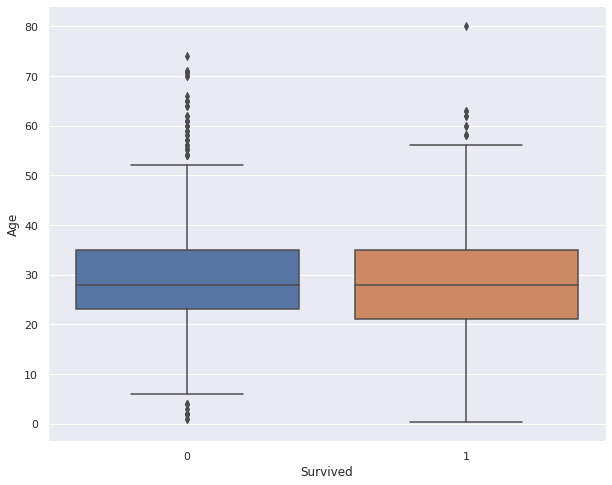

In [81]:
plt.figure(figsize=(10,8))

sns.boxplot(x=train.Survived, y=train.Age);

In [82]:
Age_0=train[train["Survived"]==0]["Age"]

In [83]:
Age_1=train[train["Survived"]==1]["Age"]

In [84]:
shapiro(Age_0)

(0.9314675331115723, 3.6840901829855374e-15)

In [85]:
shapiro(Age_1)

(0.9694448113441467, 1.3016746152061387e-06)

In [86]:
mannwhitneyu(Age_0, Age_1)

MannwhitneyuResult(statistic=89779.5, pvalue=0.1348365607443181)

# Fare

In [87]:
train.groupby("Survived")["Fare"].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,15.468944,11.630453,0.0,7.8542,10.5000,20.2500,61.9792
1,342.0,20.457185,13.750234,0.0,12.4750,14.4542,26.1875,65.0000


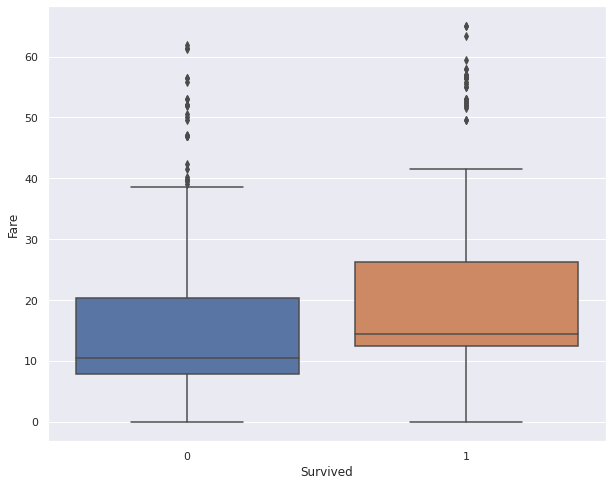

In [88]:
plt.figure(figsize=(10,8))

sns.boxplot(x=train.Survived, y=train.Fare);

In [89]:
Fare_0=train[train["Survived"]==0]["Fare"]

In [90]:
Fare_1=train[train["Survived"]==1]["Fare"]

In [91]:
shapiro(Fare_0)

(0.7899740934371948, 5.258835221471736e-26)

In [92]:
shapiro(Fare_1)

(0.8028693795204163, 4.371975239708944e-20)

In [93]:
mannwhitneyu(Fare_0, Fare_0)

MannwhitneyuResult(statistic=150700.5, pvalue=0.49996200636185756)

In [94]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,u,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,14.4542,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,u,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,u,S


In [95]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,unknown,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,unknown,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,unknown,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,unknown,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,unknown,S


# Preprocess of whole dataset

In [96]:
# dataset is updated 

dataset=pd.concat([train, test])
dataset = dataset[[train, test][0].columns]

In [97]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,u,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,14.4542,C,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,u,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,u,S


In [98]:
dataset["Pclass"]=np.where(dataset["Pclass"]==1, "1st", dataset["Pclass"])

In [99]:
dataset["Pclass"]=np.where(dataset["Pclass"]=="2", "2nd", dataset["Pclass"])

In [100]:
dataset["Pclass"]=np.where(dataset["Pclass"]=="3", "3th", dataset["Pclass"])

In [101]:
dataset["Cabin"]=dataset["Cabin"].map(lambda x: str(x)[:1])

In [102]:
dataset.drop(["Name", "Ticket"], axis=1, inplace=True)

In [103]:
dataset.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0.0,3th,male,22.0,1,0,7.2500,u,S
1,2,1.0,1st,female,38.0,1,0,14.4542,C,C
2,3,1.0,3th,female,26.0,0,0,7.9250,u,S
3,4,1.0,1st,female,35.0,1,0,53.1000,C,S
4,5,0.0,3th,male,35.0,0,0,8.0500,u,S
5,6,0.0,3th,male,28.0,0,0,8.4583,u,Q
6,7,0.0,1st,male,54.0,0,0,51.8625,E,S
7,8,0.0,3th,male,2.0,3,1,21.0750,u,S
8,9,1.0,3th,female,27.0,0,2,11.1333,u,S
9,10,1.0,2nd,female,14.0,1,0,30.0708,u,C


In [104]:
df=dataset.copy()

# OneHotEncoder for dataset

In [105]:
dms=pd.get_dummies(df[['Pclass', 'Sex', 'Cabin', 'Embarked']])

In [106]:
dms.head()

,Pclass_1st,Pclass_2nd,Pclass_3th,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [107]:
y=df["Survived"]

In [108]:
y.dropna(inplace=True)

In [109]:
y.isnull().sum()

0

In [110]:
y.shape

(891,)

In [111]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0.0,3th,male,22.0,1,0,7.2500,u,S
1,2,1.0,1st,female,38.0,1,0,14.4542,C,C
2,3,1.0,3th,female,26.0,0,0,7.9250,u,S
3,4,1.0,1st,female,35.0,1,0,53.1000,C,S
4,5,0.0,3th,male,35.0,0,0,8.0500,u,S


In [112]:
X=df.drop(["Survived", "PassengerId", 'Pclass', 'Sex', 'Cabin','Embarked'], axis=1).astype("float64")

In [113]:
x = pd.concat([X, dms[['Pclass_2nd', "Pclass_3th", 'Sex_female',"Cabin_B","Cabin_C","Cabin_D", "Cabin_E","Cabin_F", "Cabin_G" ,"Cabin_T", "Cabin_u", 'Embarked_S', "Embarked_C"]]], axis=1)

In [114]:
x.head()

,Age,SibSp,Parch,Fare,Pclass_2nd,Pclass_3th,Sex_female,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u,Embarked_S,Embarked_C
0,22.0,1.0,0.0,7.2500,0,1,0,0,0,0,0,0,0,0,1,1,0
1,38.0,1.0,0.0,14.4542,0,0,1,0,1,0,0,0,0,0,0,0,1
2,26.0,0.0,0.0,7.9250,0,1,1,0,0,0,0,0,0,0,1,1,0
3,35.0,1.0,0.0,53.1000,0,0,1,0,1,0,0,0,0,0,0,1,0
4,35.0,0.0,0.0,8.0500,0,1,0,0,0,0,0,0,0,0,1,1,0


In [115]:
x_scaled=scale(x)

In [116]:
x_sc=pd.DataFrame(x_scaled, columns=['Age', 'SibSp', 'Parch', 'Fare',
       'Pclass_2nd', 'Pclass_3th', 'Sex_female', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_u',
       'Embarked_S', 'Embarked_C'])

In [117]:
x_sc.head()

,Age,SibSp,Parch,Fare,Pclass_2nd,Pclass_3th,Sex_female,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u,Embarked_S,Embarked_C
0,-0.576088,0.481288,-0.445,-0.465009,-0.518084,0.919925,-0.743497,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,0.655011,-0.50977
1,0.663229,0.481288,-0.445,-0.254886,-0.518084,-1.087045,1.344995,-0.228584,3.595210,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,-1.853992,-1.526692,1.96167
2,-0.266258,-0.479087,-0.445,-0.445322,-0.518084,0.919925,1.344995,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,0.655011,-0.50977
3,0.430857,0.481288,-0.445,0.872286,-0.518084,-1.087045,1.344995,-0.228584,3.595210,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,-1.853992,0.655011,-0.50977
4,0.430857,-0.479087,-0.445,-0.441676,-0.518084,0.919925,-0.743497,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,0.655011,-0.50977


In [118]:
train_data=x_sc[0:len(train)]

In [119]:
test_data=x_sc[len(train):]

In [120]:
test_data.reset_index(drop=True, inplace=True)

In [121]:
train_data.tail()

,Age,SibSp,Parch,Fare,Pclass_2nd,Pclass_3th,Sex_female,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u,Embarked_S,Embarked_C
886,-0.188801,-0.479087,-0.445000,-0.297300,1.930190,-1.087045,-0.743497,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,0.655011,-0.50977
887,-0.808459,-0.479087,-0.445000,0.198534,-0.518084,-1.087045,1.344995,4.374753,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,-1.853992,0.655011,-0.50977
888,-0.111344,0.481288,1.866526,0.007492,-0.518084,0.919925,1.344995,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,0.655011,-0.50977
889,-0.266258,-0.479087,-0.445000,0.198534,-0.518084,-1.087045,-0.743497,-0.228584,3.595210,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,-1.853992,-1.526692,1.96167
890,0.198485,-0.479087,-0.445000,-0.450426,-0.518084,0.919925,-0.743497,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,-1.526692,-0.50977


In [122]:
test_data.head()

,Age,SibSp,Parch,Fare,Pclass_2nd,Pclass_3th,Sex_female,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u,Embarked_S,Embarked_C
0,0.392129,-0.479087,-0.445000,-0.448116,-0.518084,0.919925,-0.743497,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,-1.526692,-0.50977
1,1.360345,0.481288,-0.445000,-0.472301,-0.518084,0.919925,1.344995,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,0.655011,-0.50977
2,2.522204,-0.479087,-0.445000,-0.393915,1.930190,-1.087045,-0.743497,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,-1.526692,-0.50977
3,-0.188801,-0.479087,-0.445000,-0.423811,-0.518084,0.919925,-0.743497,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,0.655011,-0.50977
4,-0.576088,0.481288,0.710763,-0.318082,-0.518084,0.919925,1.344995,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-0.02765,0.539377,0.655011,-0.50977


# Machine Learning

In [123]:
x_train, x_test, y_train, y_test = train_test_split(train_data, y, 
                                                    test_size = 0.30, 
                                                    random_state = 42)

# LOGISTIC REGRESSION

In [124]:
loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(x_train,y_train)
loj_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [125]:
y_pred=loj_model.predict(x_test)

In [126]:
accuracy_score(y_test, loj_model.predict(x_test))

0.8059701492537313

In [127]:
cross_val_score(loj_model, x_test, y_test, cv = 10).mean()

0.7988603988603988

# NAIVE BAYES

In [128]:
nb = GaussianNB()
nb_model = nb.fit(x_train, y_train)
nb_model

GaussianNB(priors=None, var_smoothing=1e-09)

In [129]:
y_pred = nb_model.predict(x_test)
print(accuracy_score(y_test, y_pred))
cross_val_score(nb_model, x_test, y_test, cv = 10).mean()

0.4141791044776119


0.6636752136752138

# KNN

knn_params = {"n_neighbors": np.arange(1,50)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(x_train, y_train)

print("best params: " + str(knn_cv.best_params_))

In [130]:
knn = KNeighborsClassifier(23)
knn_tuned = knn.fit(x_train, y_train)

In [131]:
knn_tuned

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=23, p=2,
                     weights='uniform')

In [132]:
y_pred = knn_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.7723880597014925

# SVC

svc_params = {"C": np.arange(1,10)}

svc = SVC(kernel = "linear")

svc_cv_model = GridSearchCV(svc,svc_params, 
                            cv = 10, 
                            n_jobs = -1, 
                            verbose = 2)

svc_cv_model.fit(x_train, y_train)

print("best params: " + str(svc_cv_model.best_params_))

In [133]:
svc_tuned_linear=SVC(kernel = "linear", C = 1, probability=True, random_state=1)

In [134]:
svc_tuned_linear.fit(x_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [135]:
y_pred = svc_tuned_linear.predict(x_test)
accuracy_score(y_test, y_pred)

0.7873134328358209

# RBF SVC

svc_params = {"C": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
             "gamma": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100]}

svc = SVC()
svc_cv_model = GridSearchCV(svc, svc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

svc_cv_model.fit(x_train, y_train)

print("best params: " + str(svc_cv_model.best_params_))

In [136]:
svc_tuned=SVC(C = 1, gamma = 0.1, probability=True,random_state=1)

In [137]:
svc_tuned.fit(x_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [138]:
y_pred=svc_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.7947761194029851

# ANN MLP

mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005, 0.0001,0.00001],
              "hidden_layer_sizes": [(10,10,10),
                                     (100,100,100),
                                     (100,100),
                                     (3,5), 
                                     (5, 3)],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": ["relu","logistic"]}

mlpc = MLPClassifier()
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

mlpc_cv_model.fit(x_train, y_train)

print("best params: " + str(mlpc_cv_model.best_params_))

In [139]:
mlpc_tuned = MLPClassifier(activation = "relu", 
                           alpha = 0.0001, 
                           hidden_layer_sizes = (100, 100, 100),
                           solver = "sgd", random_state=1)

In [140]:
mlpc_tuned.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [141]:
y_pred = mlpc_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.7873134328358209

# CART

cart_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50)) }

cart = tree.DecisionTreeClassifier()
cart_cv = GridSearchCV(cart, cart_grid, cv = 10, n_jobs = -1, verbose = 2)
cart_cv_model = cart_cv.fit(x_train, y_train)

print("best params: " + str(cart_cv_model.best_params_))

In [142]:
cart = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 3, random_state=1)
cart_tuned = cart.fit(x_train, y_train)

In [143]:
cart_tuned

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [144]:
y_pred = cart_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.8022388059701493

# Random Forests

rf_params = {"max_depth": [2,5,8,10],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2) 

rf_cv_model.fit(x_train, y_train)

print("best params: " + str(rf_cv_model.best_params_))

In [145]:
rf_tuned = RandomForestClassifier(max_depth = 8, 
                                  max_features = 5, 
                                  min_samples_split = 2,
                                  n_estimators = 1000, random_state=1)

rf_tuned.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [146]:
y_pred = rf_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.7985074626865671

# GBM

gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}

gbm = GradientBoostingClassifier()

gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)

gbm_cv.fit(x_train, y_train)

print("best params: " + str(gbm_cv.best_params_))

In [147]:
gbm = GradientBoostingClassifier(learning_rate = 0.1, 
                                 max_depth = 3,
                                min_samples_split = 5,
                                n_estimators = 100, random_state=1)

In [148]:
gbm_tuned =  gbm.fit(x_train,y_train)

In [149]:
gbm_tuned

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [150]:
y_pred = gbm_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.8134328358208955

# XGBoost

xgb_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_samples_split": [2,5,10]}

xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)

xgb_cv_model.fit(x_train, y_train)

xgb_cv_model.best_params_

In [151]:
xgb = XGBClassifier(learning_rate = 0.02, 
                    max_depth = 3,
                    min_samples_split = 2,
                    n_estimators = 2000,
                    subsample = 1)

In [152]:
xgb_tuned =  xgb.fit(x_train,y_train)

In [153]:
xgb_tuned

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, min_samples_split=2, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [154]:
y_pred = xgb_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.7910447761194029

# Light GBM

lgbm_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_child_samples": [5,10,20]}

lgbm = LGBMClassifier()

lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, 
                             cv = 10, 
                             n_jobs = -1, 
                             verbose = 2)

lgbm_cv_model.fit(x_train, y_train)

lgbm_cv_model.best_params_

In [155]:
lgbm = LGBMClassifier(learning_rate = 0.02, 
                       max_depth = 4,
                       subsample = 0.6,
                       n_estimators = 500,
                       min_child_samples = 20,random_state=1)

In [156]:
lgbm_tuned = lgbm.fit(x_train,y_train)

In [157]:
lgbm_tuned

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.6, subsample_for_bin=200000, subsample_freq=0)

In [158]:
y_pred = lgbm_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.7910447761194029

# CatBoost

catb_params = {
    'iterations': [200,500],
    'learning_rate': [0.01,0.05, 0.1],
    'depth': [3,5,8] }

catb = CatBoostClassifier()
catb_cv_model = GridSearchCV(catb, catb_params, cv=5, n_jobs = -1, verbose = 2)
catb_cv_model.fit(x_train, y_train)

catb_cv_model.best_params_

In [159]:
catb = CatBoostClassifier(iterations = 200, 
                          learning_rate = 0.1, 
                          depth = 5, verbose=False, random_seed=1)

catb_tuned = catb.fit(x_train, y_train)

In [160]:
catb_tuned

In [161]:
y_pred = catb_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.8022388059701493

# Importance

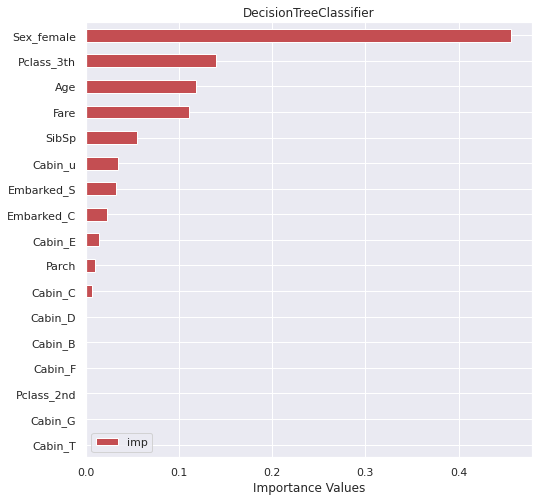

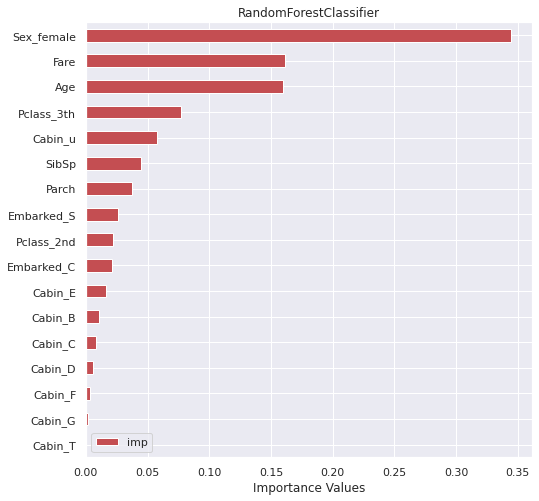

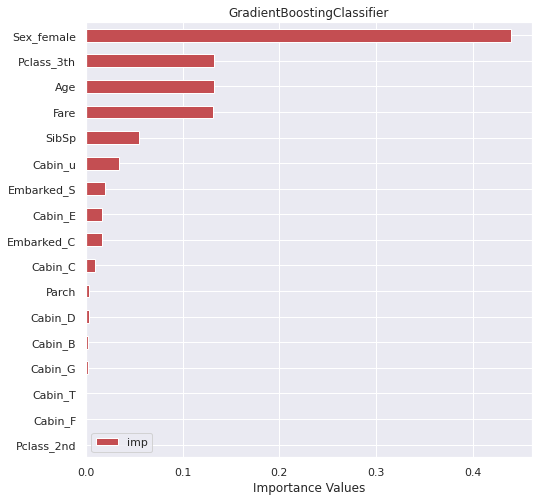

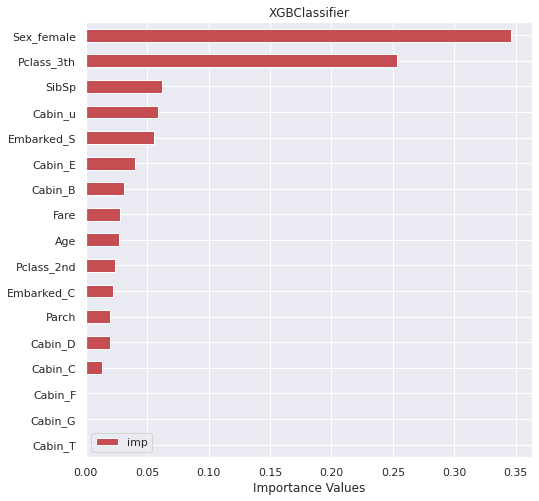

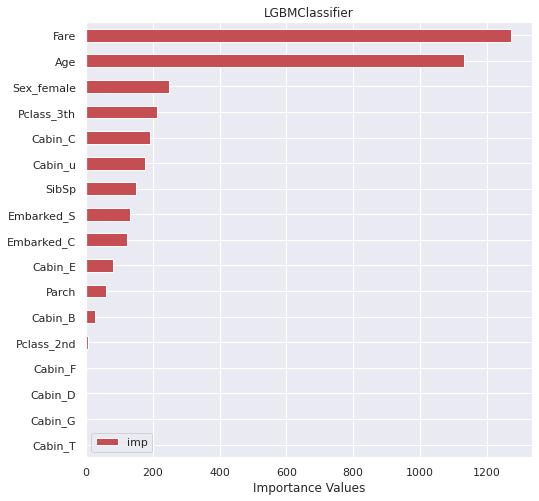

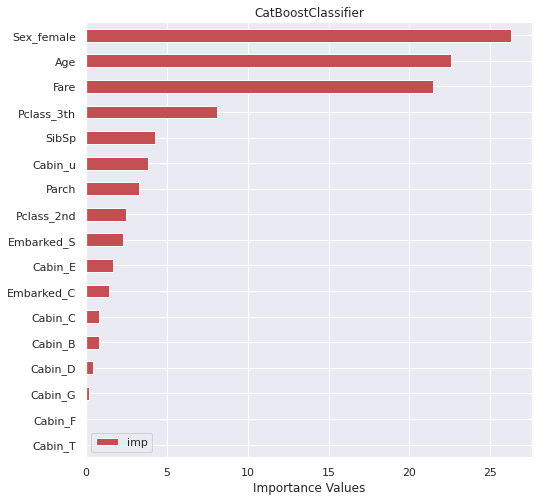

In [162]:
models_importance = [
{
    'label': 'DecisionTreeClassifier',
    'model': cart_tuned,
},
{
    'label': 'RandomForestClassifier',
    'model': rf_tuned,
},
{
    'label': 'GradientBoostingClassifier',
    'model': gbm_tuned,
},
{
    'label': 'XGBClassifier',
    'model': xgb_tuned,
},
{
    'label': 'LGBMClassifier',
    'model': lgbm_tuned,
},
{
    'label': 'CatBoostClassifier',
    'model': catb_tuned,
}
]

for model in models_importance:
    names = model['label']
    model = model["model"]    
    model_imp=pd.DataFrame(model.feature_importances_, index = x_train.columns)
    model_imp.columns=["imp"]
    model_imp.sort_values(by = "imp", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")
    plt.title(names)
    plt.xlabel("Importance Values")

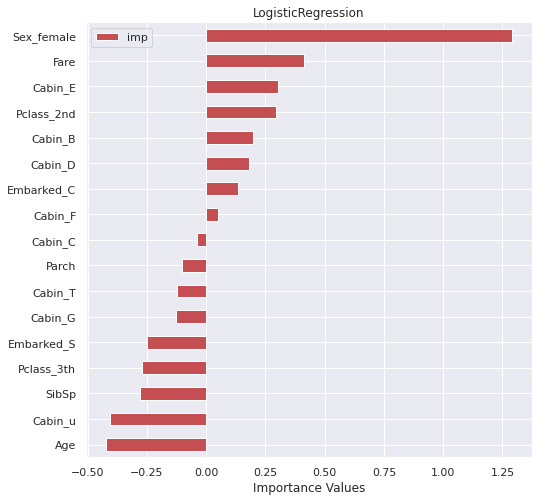

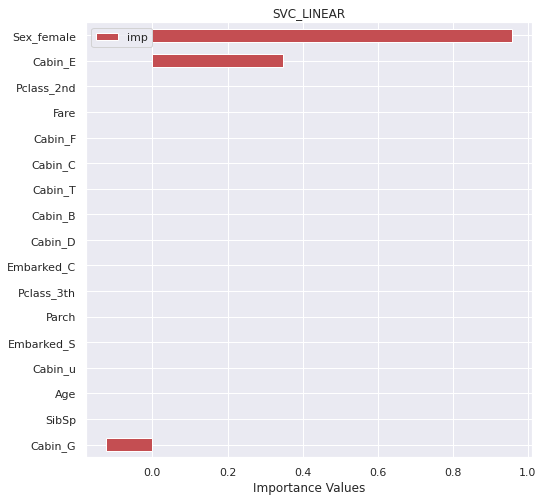

In [163]:
models_importance = [
{
    'label': 'LogisticRegression',
    'model': loj_model,
},
{
    'label': 'SVC_LINEAR',
    'model': svc_tuned_linear,
}
]


for model in models_importance:
    names = model['label']
    model = model["model"]
    coef=np.array(model.coef_)
    model_imp=pd.DataFrame(coef.flatten(), index = x_train.columns)
    model_imp.columns=["imp"]
    model_imp.sort_values(by = "imp", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")
    plt.title(names)
    plt.xlabel("Importance Values")

# Comparison of All Models

In [164]:
models = [
{
    'label': 'KNeighborsClassifier',
    'model': knn_tuned,
},
{
    'label': 'LogisticRegression',
    'model': loj_model,
},
{
    'label': 'SVC_LINEAR',
    'model': svc_tuned_linear,
},
{
    'label': 'SVC_RBF',
    'model': svc_tuned,
},
{
    'label': 'GaussianNB',
    'model': nb_model,
},
{
    'label': 'MLPClassifier',
    'model': mlpc_tuned,
},
{
    'label': 'DecisionTreeClassifier',
    'model': cart_tuned,
},
{
    'label': 'RandomForestClassifier',
    'model': rf_tuned,
},
{
    'label': 'GradientBoostingClassifier',
    'model': gbm_tuned,
},
{
    'label': 'XGBClassifier',
    'model': xgb_tuned,
},
{
    'label': 'LGBMClassifier',
    'model': lgbm_tuned,
},
{
    'label': 'CatBoostClassifier',
    'model': catb_tuned,
}
]

for model in models:
    names = model['label']
    model = model["model"]
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusionmatrix=confusion_matrix(y_test, y_pred)
    (TN, FP, FN, TP) = confusionmatrix.ravel()
    TPR = TP/(TP+FN) 
    TNR = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    FPR = FP/(FP+TN)
    FNR = FN/(TP+FN)
    print("-"*28)
    print(names + ":" )
    print("Accuracy: {:.4%}".format(accuracy))
    print("TPR     : {:.4%}".format(TPR))
    print("TNR     : {:.4%}".format(TNR))
    print("PPV     : {:.4%}".format(PPV))
    print("NPV     : {:.4%}".format(NPV))
    print("FPR     : {:.4%}".format(FPR))
    print("FNR     : {:.4%}".format(FNR))

----------------------------
KNeighborsClassifier:
Accuracy: 77.2388%
TPR     : 63.9640%
TNR     : 86.6242%
PPV     : 77.1739%
NPV     : 77.2727%
FPR     : 13.3758%
FNR     : 36.0360%
----------------------------
LogisticRegression:
Accuracy: 80.5970%
TPR     : 72.0721%
TNR     : 86.6242%
PPV     : 79.2079%
NPV     : 81.4371%
FPR     : 13.3758%
FNR     : 27.9279%
----------------------------
SVC_LINEAR:
Accuracy: 78.7313%
TPR     : 71.1712%
TNR     : 84.0764%
PPV     : 75.9615%
NPV     : 80.4878%
FPR     : 15.9236%
FNR     : 28.8288%
----------------------------
SVC_RBF:
Accuracy: 79.4776%
TPR     : 66.6667%
TNR     : 88.5350%
PPV     : 80.4348%
NPV     : 78.9773%
FPR     : 11.4650%
FNR     : 33.3333%
----------------------------
GaussianNB:
Accuracy: 41.4179%
TPR     : 99.0991%
TNR     : 0.6369%
PPV     : 41.3534%
NPV     : 50.0000%
FPR     : 99.3631%
FNR     : 0.9009%
----------------------------
MLPClassifier:
Accuracy: 78.7313%
TPR     : 67.5676%
TNR     : 86.6242%
PPV     : 78.125

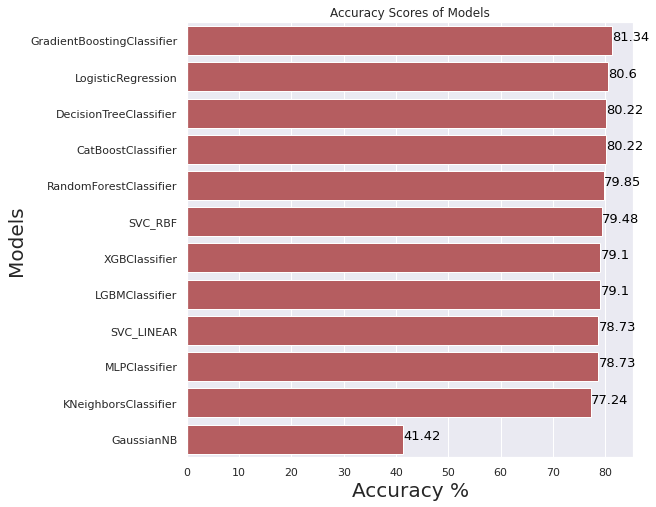

In [165]:
result = []

results = pd.DataFrame(columns= ["Models","Accuracy"])

for model in models:
    names = model['label']
    model = model["model"]
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)    
    result = pd.DataFrame([[names, accuracy*100]], columns= ["Models","Accuracy"])
    results = results.append(result)


    
results=results.sort_values(by="Accuracy", ascending=False).reset_index()
results.drop(["index"], axis=1, inplace=True)
g=sns.barplot(x= 'Accuracy', y = 'Models', data=results, color="r")
g.set_xlabel("Accuracy",fontsize=20)
g.set_ylabel("Models",fontsize=20)

for index, row in results.iterrows():
    g.text(row.Accuracy, row.name, round(row.Accuracy,2), color='black', horizontalalignment='left', fontsize=13)

plt.xlabel('Accuracy %')
plt.title('Accuracy Scores of Models');  

# ROC Curve

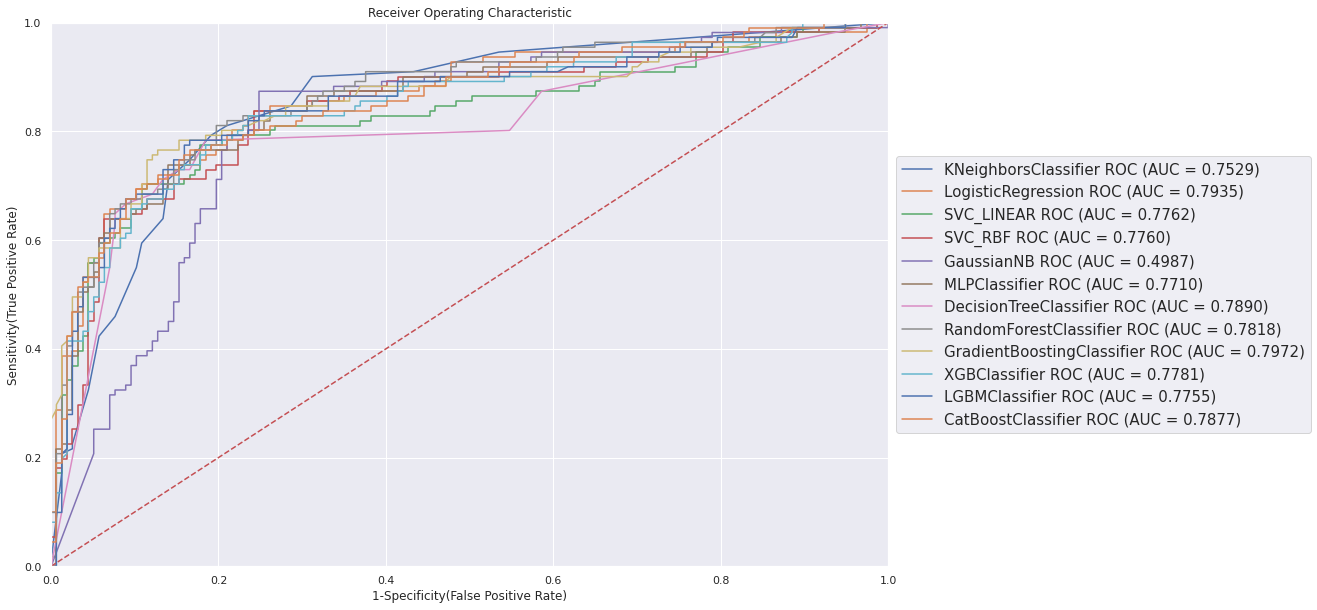

In [166]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()


# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.4f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) , fontsize=15)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()   # Display

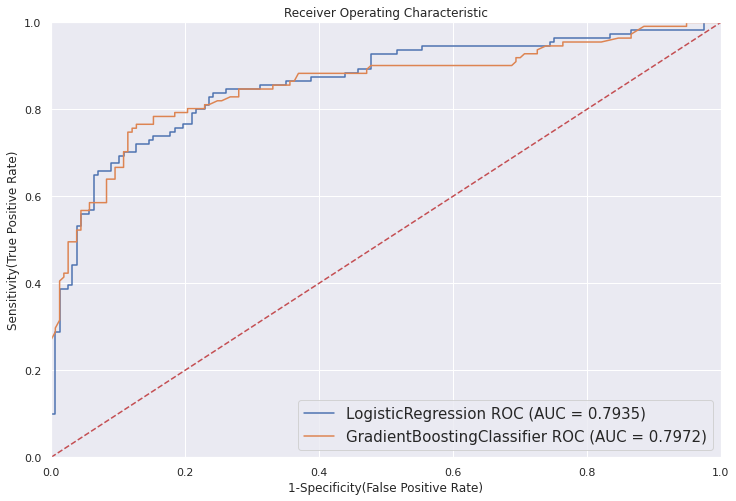

In [167]:
from sklearn import metrics

plt.figure()

# Add the models to the list that you want to view on the ROC plot
modelsROC = [
{
    'label': 'LogisticRegression',
    'model': loj_model,
},
{
    'label': 'GradientBoostingClassifier',
    'model': gbm_tuned,
}
]

# Below for loop iterates through your models list
for m in modelsROC:
    model = m['model'] # select the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.4f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='right corner', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()   # Display

# Test Data Predictions

In [168]:
test_data_y_pred=gbm_tuned.predict(test_data)

In [169]:
survived=pd.concat([test["PassengerId"], (pd.DataFrame(test_data_y_pred, columns=["Survived"]))], axis=1)

In [170]:
survived["Survived"]=survived["Survived"].astype("int64")

In [171]:
survived

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [172]:
survived.to_csv("Survived_Prediction.csv")